![ga4](https://www.google-analytics.com/collect?v=2&tid=G-6VDTYWLKX6&cid=1&en=page_view&sid=1&dl=statmike%2Fvertex-ai-mlops%2FApplied+GenAI&dt=Vertex+AI+GenAI+For+Document+Q%26A+-+Municipal+Securities.ipynb)

# Document Q&A: Local Government Trends

**What?**

Ask question of a market report on local government trends.  

**Sources:**

PDFs:
- [2023 Look Ahead: 25 Topics to Watch in Local Governments This Year](https://fiscalnote-marketing.s3.amazonaws.com/Trendspotting-Report.pdf) - 13 pages.
- [How Local Governments Have Taken Advantage of Major Federal Programs](https://fiscalnote-marketing.s3.amazonaws.com/Local-funding-report.pdf) - 12 pages.
- Source: Curate, Part of FiscalNote

**Tools:**
- Vertex AI LLM Embedding API
  - `vertexai.preview.language_models.TextEmbeddingModel.from_pretrained('embedding-gecko@001')`
- Vertex AI GenAI Language Model API
  - `vertexai.preview.language_models.TextGenerationModel.from_pretrained('text@bison-001')`
- Input file processing into documents/elements with GCP Document AI
  - `google.cloud.documentai.DocumentProcessorServiceClient()`
- Embedding search: with [ScaNN](https://github.com/google-research/google-research/tree/master/scann), [chromadb](https://github.com/chroma-core/chroma), [Vertex AI Matching Engine](https://cloud.google.com/vertex-ai/docs/matching-engine/overview)
  - this example uses `ScaNN` in the notebook

---

**Google Cloud Vertex AI Generative AI Support**

Vertex AI Generative AI gives access to Google's large genearative AI models and also enables you to test, tune, and deploy them for your applications. Get an overview [here](https://cloud.google.com/vertex-ai/docs/generative-ai/learn/overview).

---

**How:**

- Create documents from the source information.
  - <u>Definition</u>: a document is a section of the rules
- Create embeddings for each document
- Ask a question
  - Create an embedding of the question
  - Use vector similarity to retrieve embeddings for related documents
  - Retrieve the documents associated with returned embeddings
  - Prepare a prompt to answer the question using the documents as context
- Present the response as an answer with links to the related documents (sections of the document).

**What is Unique?**

An LLM is likely unexposed to a users private content.  This appoach constructs a summarization prompt for an LLM by first retriving context for the question from the users documents using embeddings.  This also allows the response to be accompanied by direct reference to the users documentation used in the prompt.

**Notes**

- An LLM is likely trained on many sources that probably include lots of general knowledge, even information like what is used here.  It is also likely knowledgable of past outdated information which can be a benefit - or detriment - to accuracy.  This approach directly uses the version of the document that currently applies.

**References**

- [Vertex AI GenAI Studio](https://cloud.google.com/vertex-ai/docs/generative-ai/learn/overview)
    - Vertex AI [Python Client](https://cloud.google.com/python/docs/reference/aiplatform/latest)
- [Document AI](https://cloud.google.com/document-ai/docs/overview)
    - Document AI [Parsers](https://cloud.google.com/document-ai/docs/processors-list)
    - Document AI [Python Client](https://cloud.google.com/python/docs/reference/documentai/latest)

---
## Overview

<p><center>
    <img alt="Overview Chart" src="../architectures/notebooks/applied/genai/doc_qa.png" width="55%">
</center><p>


---
## Colab Setup

To run this notebook in Colab click [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/statmike/vertex-ai-mlops/blob/main/Applied%20GenAI/Vertex%20AI%20GenAI%20For%20Document%20Q&A%20-%20Municipal%20Securities.ipynb) and run the cells in this section.  Otherwise, skip this section.

This cell will authenticate to GCP (follow prompts in the popup).

In [1]:
PROJECT_ID = 'statmike-mlops-349915' # replace with project ID

In [2]:
try:
    import google.colab
    from google.colab import auth
    auth.authenticate_user()
    !gcloud config set project {PROJECT_ID}
except Exception:
    pass

---
## Installs

In [ ]:
# Vertex AI GenAI Studio SDK - Update the aiplatform SDK
!pip install google.cloud.aiplatform -U -q --user

# for working with embeddings locally
!pip install scann -q --user

# For GCP DocAI and presentation of results
!pip install google-cloud-documentai -q --user
!pip install PyPDF2 -U -q --user
!pip install Pillow -U -q --user

In [47]:
# Enable Document AI For This Project
!gcloud services enable documentai.googleapis.com
# Enable Vertex AI For This Project
!gcloud services enable aiplatform.googleapis.com

The `aiplatform` version needs to be 1.25.0 or higher for the LLM functionality:

In [3]:
import google.cloud.aiplatform as aiplatform
aiplatform.__version__

'1.25.0'

**RESTART RUNTIME**

In [ ]:
import IPython
app = IPython.Application.instance()
app.kernel.do_shutdown(True)

---
## Setup

Inputs

In [1]:
project = !gcloud config get-value project
PROJECT_ID = project[0]
PROJECT_ID

'statmike-mlops-349915'

In [82]:
REGION = 'us-central1'
EXPERIMENT = 'local-government-trends'
SERIES = 'applied-genai'

# save results in: GCS, BQ, ALL
SAVE_IN = 'GCS'
# retrieve results from: GCS, BQ.  If not present then it will run parsing and embedding.
RETRIEVE_FROM = 'GCS'

# make this the gcs bucket for storing files
GCS_BUCKET = PROJECT_ID 

# make this the BQ Project / Dataset / Table prefix to store results
BQ_PROJECT = PROJECT_ID
BQ_DATASET = SERIES.replace('-', '_')
BQ_TABLE = EXPERIMENT

# location for the source documents (PDF): can be http or gs://, a list of one or more document links
source_documents = [
    'https://fiscalnote-marketing.s3.amazonaws.com/Trendspotting-Report.pdf',
    'https://fiscalnote-marketing.s3.amazonaws.com/Local-funding-report.pdf',
    './path/to/something.rtf'
]
#source_documents = [f'gs://{GCS_BUCKET}/{SERIES}/{EXPERIMENT}/filename.pdf']

# first question to ask
question = "List the policy issues are covered by the reports?"

Packages

In [3]:
import os
import io
import json
import base64
import requests
import concurrent.futures
import time

import PyPDF2
import IPython
import PIL
import PIL.ImageFont, PIL.Image, PIL.ImageDraw
import shapely

import scann
import numpy as np

import vertexai.preview.language_models
from google.cloud import aiplatform
from google.cloud import documentai
from google.cloud.documentai_v1 import Document
from google.cloud import storage
from google.cloud import bigquery

2023-06-01 23:24:46.642181: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-01 23:24:49.832069: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/local/cuda/extras/CUPTI/lib64
2023-06-01 23:24:49.832258: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/loca

Clients

In [4]:
# vertex ai clients
vertexai.init(project = PROJECT_ID, location = REGION)
aiplatform.init(project = PROJECT_ID, location = REGION)

# document AI client
LOCATION = REGION.split('-')[0]
docai_client = documentai.DocumentProcessorServiceClient(
    client_options = dict(api_endpoint = f"{LOCATION}-documentai.googleapis.com")
)

# bigquery client
bq = bigquery.Client(project = PROJECT_ID)

# gcs client: assumes bucket already exists
gcs = storage.Client(project = PROJECT_ID)
bucket = gcs.bucket(GCS_BUCKET)

---
## Vertex LLM Setup

- TextEmbeddingModel [Guide](https://cloud.google.com/vertex-ai/docs/generative-ai/embeddings/get-text-embeddings)
    - TextEmbeddingModel [API](https://cloud.google.com/python/docs/reference/aiplatform/latest/vertexai.preview.language_models.TextEmbeddingModel)
- TextGenerationModel [Guide](https://cloud.google.com/vertex-ai/docs/generative-ai/text/test-text-prompts)
    - TextGenerationModel [API](https://cloud.google.com/python/docs/reference/aiplatform/latest/vertexai.preview.language_models.TextGenerationModel)

In [5]:
# create links to model: embedding api and text generation
embedding_model = vertexai.preview.language_models.TextEmbeddingModel.from_pretrained('textembedding-gecko@001')
textgen_model = vertexai.preview.language_models.TextGenerationModel.from_pretrained('text-bison@001')

Test embedding model:

In [6]:
embedding_model.get_embeddings([question])[0].values[0:5]

[0.04744141921401024,
 0.004469648934900761,
 -0.024847587570548058,
 -0.04290061816573143,
 0.0019053444266319275]

Test test generation (llm) model:

In [83]:
textgen_model.predict(question)

The policy issues covered by the reports are:

* The impact of the Affordable Care Act on the uninsured population
* The cost of health care
* The quality of health care
* The role of the government in health care
* The future of health care in the United States

---
## Get/Create Document AI Processors

Using the [General Form Processor](https://cloud.google.com/document-ai/docs/processors-list#general_processors) and [Document Splitter](https://cloud.google.com/document-ai/docs/processors-list#processor_doc-splitter).



In [8]:
PARSER_DISPLAY_NAME = 'my_general_processor'
PARSER_TYPE = 'FORM_PARSER_PROCESSOR'
PARSER_VERSION = 'pretrained-form-parser-v2.0-2022-11-10'

for p in docai_client.list_processors(parent = f'projects/{PROJECT_ID}/locations/{LOCATION}'):
  if p.display_name == PARSER_DISPLAY_NAME:
    parser = p
    print('Retrieved Existing Parser')
if 'parser' not in locals():
  parser = docai_client.create_processor(
      parent = f'projects/{PROJECT_ID}/locations/{LOCATION}',
      processor = dict(display_name = PARSER_DISPLAY_NAME, type_ = PARSER_TYPE, default_processor_version = PARSER_VERSION)
  )
  print('Created New Parser')

parser

Retrieved Existing Parser


name: "projects/1026793852137/locations/us/processors/99dc9d70b803f826"
type_: "FORM_PARSER_PROCESSOR"
display_name: "my_general_processor"
state: ENABLED
process_endpoint: "https://us-documentai.googleapis.com/v1/projects/1026793852137/locations/us/processors/99dc9d70b803f826:process"
create_time {
  seconds: 1683799767
  nanos: 293339000
}
default_processor_version: "projects/1026793852137/locations/us/processors/99dc9d70b803f826/processorVersions/pretrained-form-parser-v1.0-2020-09-23"

---
## Get The Documents

Get the source PDF(s) from GCS or a URL and store as a list of pages for each file: `file_pages`.

Get Location of Files

In [9]:
document_locations = []
for source_document in source_documents:
    if source_document.startswith('http'):
        document_locations.append('URL')
        print(f'Use requests to get online document: {source_document}')
    elif source_document.startswith('gs'):
        document_locations.append('GCS')
        print(f'Use GCS to get document in GCS: {source_document}')
    else:
        document_locations.append('UNKNOWN')
        print(f'The source_document variable points to a document in an unknown location type (not gs:// or http): {source_document}')

Use requests to get online document: https://fiscalnote-marketing.s3.amazonaws.com/Trendspotting-Report.pdf
Use requests to get online document: https://fiscalnote-marketing.s3.amazonaws.com/Local-funding-report.pdf
The source_document variable points to a document in an unknown location type (not gs:// or http): ./path/to/something.rtf


Import the PDF to memory as bytes:

In [10]:
imported_documents = []
for s, source_document in enumerate(source_documents):
    if document_locations[s] == 'URL':
        imported_documents.append(requests.get(source_document).content)
    elif document_locations[s] == 'GCS':
        blob = bucket.blob(source_document.split(f'gs://{GCS_BUCKET}/')[1])
        imported_documents.append(blob.download_as_bytes())
    elif document_locations[s] == 'UNKNOWN':
        imported_documents.append(None)

In [12]:
type(imported_documents[0])

bytes

Convert from bytes to PDF:

In [13]:
converted_documents = []
for imported_document in imported_documents:
    if imported_document:
        converted_documents.append(PyPDF2.PdfReader(io.BytesIO(imported_document)))
    else:
        converted_documents.append(None)

In [14]:
type(converted_documents[0])

PyPDF2._reader.PdfReader

Review number of pages per PDF:

In [15]:
for f, file in enumerate(converted_documents):
    if file:
        print(f"{source_documents[f]} has {len(file.pages)} pages")

https://fiscalnote-marketing.s3.amazonaws.com/Trendspotting-Report.pdf has 13 pages
https://fiscalnote-marketing.s3.amazonaws.com/Local-funding-report.pdf has 12 pages


Split PDF(s) in list of individual pages for each file:

In [16]:
raw_files_pages = []
for converted_document in converted_documents:
    if converted_document:
        pages = []
        for page_num, page in enumerate(converted_document.pages, 1):
            writer = PyPDF2.PdfWriter()
            writer.add_page(page)
            with io.BytesIO() as bytes_stream:
                pages.append(writer.write(bytes_stream)[1].getbuffer().tobytes())
        raw_files_pages.append(pages)
    else:
        raw_files_pages.append(None)

---
## Retrieve Files From Previous Run on GCS Or BigQuery

This uses the input parameter set above: `RETRIEVE_FROM`.  If it is set to `BQ` or `GCS` then it will check the source for an available prior run and retrieve it if it exists.


Function to check for existance of BigQuery Table:

In [31]:
def bq_table_check(table):
    from google.cloud.exceptions import NotFound
    try:
        bq.get_table(table)
        return True
    except NotFound:
        return False
    
bq_table_check(f'{BQ_DATASET}.{BQ_TABLE}_documents')

False

In [21]:
if RETRIEVE_FROM == 'GCS' and len(list(bucket.list_blobs(prefix = f'{SERIES}/{EXPERIMENT}/results.json'))) > 0:
    print('Copying previous run from GCS')
    
    # load results: the raw data from docai parsing
    blob = bucket.blob(f'{SERIES}/{EXPERIMENT}/results.json')
    results = [json.loads(line) for line in blob.download_as_text().splitlines()]
    
    # load documents: the prepared results from the docai parsing results
    blob = bucket.blob(f'{SERIES}/{EXPERIMENT}/documents.json')
    documents = [json.loads(line) for line in blob.download_as_text().splitlines()]
    
    # load page images for presentation: stored in the results
    page_images = []
    for r, result in enumerate(results):
        document_image = PIL.Image.open(
            io.BytesIO(
                 # stored as string, use .encode() to convert to bytes, use base64.decodebytes to decode
                base64.decodebytes(result['pages'][0]['image']['content'].encode('utf-8'))
            )
        )
        page_images.append(document_image)    
    
    # Set Indicator to prevent redoing the parsing later in this notebook
    PRIOR_PARSE = True
elif RETRIEVE_FROM == 'BQ' and bq_table_check(f'{BQ_DATASET}.{BQ_TABLE}_documents'):
    print('Copying previous run from BigQuery')
    
    # load results: the raw data from docai parsing
    results = bq.query(f'SELECT * FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_results` ORDER BY metadata.row').to_dataframe().to_dict('records')
    
    # load documents: the perpared results from the docai parsing results
    documents = bq.query(f'SELECT * FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_documents` ORDER BY metadata.row').to_dataframe().to_dict('records')
    
    # load page images for presentation: stored in the results
    page_images = []
    for r, result in enumerate(results):
        document_image = PIL.Image.open(
            io.BytesIO(
                 # stored as base64 encoded bytes in BQ and retrieved in that format
                result['pages'][0]['image']['content']
            )
        )
        page_images.append(document_image) 
    
    # Set Indicator to prevent redoing the parsing later in this notebook
    PRIOR_PARSE = True
else:
    print('No previous run available to copy over')
    PRIOR_PARSE = False

No previous run available to copy over


---
## Parse Documents

Results of:
- [google.cloud.documentai.DocumentProcessorServiceClient().process_document()](https://cloud.google.com/python/docs/reference/documentai/latest/google.cloud.documentai_v1.services.document_processor_service.DocumentProcessorServiceClient#google_cloud_documentai_v1_services_document_processor_service_DocumentProcessorServiceClient_process_document)
  - are in the format of
    - [google.cloud.documentai_v1.types.ProcessResponse()](https://cloud.google.com/python/docs/reference/documentai/latest/google.cloud.documentai_v1.types.ProcessResponse)
      - which contains `.document` in the format of:
        - [google.cloud.documentai_v1.types.Document](https://cloud.google.com/python/docs/reference/documentai/latest/google.cloud.documentai_v1.types.Document)

Converting the Document to:
- JSON with .to_json()
- dictionary with .to_dict()

**Document AI Notes:**
- In this application we are using online processing.  This has a limit of 15 pages per document.  Switch to batch increases this to 100 pages for the Form Parser (General).
- Online processing has a default qouta of 120 request per minute per project. The code below implement waiting time to avoid this limit.
- [Reference](https://cloud.google.com/document-ai/quotas)

In [21]:
rate_limit_minute = 120
adjust_rate_limit = rate_limit_minute / 2

In [22]:
def docai_runner(p, start, raw_document_page):
  sleep_time = (p * (60/adjust_rate_limit)) - (time.time() - start)
  if sleep_time > 0: time.sleep(sleep_time)

  return (p, docai_client.process_document(request = dict(raw_document = raw_document_page, name = parser.name)))

In [24]:
if PRIOR_PARSE:
    print('Using Prior Results')
else:
    print('No Prior Results, Parsing with Document AI')
    files_pages = []
    for n, pages in enumerate(raw_files_pages):
        if pages:
            print(f"The Expected runtime for parsing document {n + 1} of {len(raw_files_pages)} is {(len(pages)/adjust_rate_limit):.2f} minutes")
            file_pages = [None] * len(pages)
            start = time.time()
            with concurrent.futures.ThreadPoolExecutor(max_workers = len(pages)) as executor:
                futures = [
                    executor.submit(
                        docai_runner,
                        p, start,
                        documentai.RawDocument(content = pdf, mime_type = 'application/pdf')
                    ) for p, pdf in enumerate(pages)
                ]
                for future in concurrent.futures.as_completed(futures):
                    file_pages[future.result()[0]] = (Document.to_dict(future.result()[1].document))
            files_pages.append(file_pages)
        else:
            files_pages.append(None)

No Prior Results, Parsing with Document AI
The Expected runtime for parsing document 1 of 3 is 0.22 minutes
The Expected runtime for parsing document 2 of 3 is 0.20 minutes


For each pages dictionary, add the path, file, page, and embedding of the full full pages OCR results:

In [43]:
if PRIOR_PARSE:
    print('Using Prior Results')
else:
    print('No Prior Results, Using Document AI Parsing')
    for f, file in enumerate(files_pages):
        if file:
            
            for p, page in enumerate(file):
                document_image = PIL.Image.open(
                    io.BytesIO(
                        base64.decodebytes(page['pages'][0]['image']['content'].encode('utf-8'))
                    )
                )
                page['path'] = source_documents[f][:(-1*len(source_documents[f].split('/')[-1]))]
                page['file'] = source_documents[f].split('/')[-1]
                page['page'] = p+1
                page['dimensions'] = document_image.size
                if page['text']:
                    page['embedding'] = embedding_model.get_embeddings([page['text']])[0].values
                else:
                    page['embedding'] = []

No Prior Results, Using Document AI Parsing


### Parse Elements From Documents

Elements to capture here are paragraphs and tables.  If a paragraph overlaps a table then include it within the table.

In [97]:
if PRIOR_PARSE:
    print('Using Prior Document Preparation')
else:
    files_pages_elements = []
    
    for f, file in enumerate(files_pages):
        if file:
            for p, page in enumerate(file):
                
                # parse tables from page:
                tables = []
                for t, table in enumerate(page['pages'][0]['tables']):
                    
                    table_txt = ''
                    if 'text_anchor' in table['layout'].keys():
                        for s, segment in enumerate(table['layout']['text_anchor']['text_segments']):
                            if t == 0 and s == 0: start = 0
                            else: start = int(segment['start_index'])
                            end = int(segment['end_index'])
                            table_txt += page['text'][start:end+t]

                    vertices = []
                    for vertex in table['layout']['bounding_poly']['normalized_vertices']:
                        vertices.append(dict(x = vertex['x'] * page['dimensions'][0], y = vertex['y'] * page['dimensions'][1]))
                    tables.append(shapely.geometry.Polygon([(v['x'], v['y']) for v in vertices]))

                    files_pages_elements.append(
                        dict(
                            page_content = table_txt,
                            metadata = dict(
                                file_index = f,
                                page_index = p,
                                table = t+1,
                                vertices = vertices
                            )
                        )
                    )
                
                # parse paragraphs from page - not in tables or overlapping tables
                for g, paragraph in enumerate(page['pages'][0]['paragraphs']):
                    
                    paragraph_txt = ''
                    for s, segment in enumerate(paragraph['layout']['text_anchor']['text_segments']):
                        if p == 0 and s == 0: start = 0
                        else: start = int(segment['start_index'])
                        end = int(segment['end_index'])
                        paragraph_txt += page['text'][start:end+1]

                    vertices = []
                    for vertex in paragraph['layout']['bounding_poly']['normalized_vertices']:
                        vertices.append(dict(x = vertex['x'] * page['dimensions'][0], y = vertex['y'] * page['dimensions'][1]))

                    # only use paragraph that are not within table boundaries
                    use_paragraph = True
                    for t_shape in tables:
                        p_shape = shapely.geometry.Polygon([(v['x'], v['y']) for v in vertices])
                        if p_shape.intersects(t_shape): use_paragraph = False

                    if use_paragraph:
                        files_pages_elements.append(
                            dict(
                                page_content = paragraph_txt,
                                metadata = dict(
                                    file_index = f,
                                    page_index = p,
                                    paragraph = g+1,
                                    vertices = vertices
                                )
                            )
                        )

---
## Get Embeddings


In [98]:
rate_limit_minute = 400 # up to 600 now 6/1/2023

In [99]:
if PRIOR_PARSE:
    print('Embeddings created on previous run.')
else:
    start = time.time()
    for e, element in enumerate(files_pages_elements):
        if e % rate_limit_minute == 0:
            time.sleep(((time.time() - start) % 60) + 10)
            start = time.time()
        if element['page_content']: element['embedding'] = embedding_model.get_embeddings([element['page_content']])[0].values
        else: element['embedding'] = []

## Create Embeddings Database


Use [ScaNN](https://github.com/google-research/google-research/tree/master/scann) to build a local vector search capability.

In [100]:
tempx = []
len(tempx)

0

In [101]:
n = 0
embedsize = 0
while embedsize == 0:
    embedsize = len(files_pages_elements[n]['embedding'])
    n+1
print(n, embedsize)

0 768


In [102]:
index = np.empty((len(files_pages_elements), embedsize))
index.shape

(417, 768)

In [103]:
if type(files_pages_elements[n]['embedding']) == list:
    for i in range(index.shape[0]):
        if files_pages_elements[i]['page_content']:
            index[i] = files_pages_elements[i]['embedding']        
elif type(files_pages_elements[0]['embedding']) == np.ndarray: # retrieved from BigQuery
    for i in range(index.shape[0]):
        if files_pages_elements[i]['page_content']:
            index[i] = files_pages_elements[i]['embedding'].tolist()        

In [104]:
normalized_index = index / np.linalg.norm(index, axis=1)[:, np.newaxis]

In [105]:
# configure ScaNN as a tree - asymmetric hash hybrid with reordering
# anisotropic quantization as described in the paper; see README

# use scann.scann_ops.build() to instead create a TensorFlow-compatible searcher
builder = scann.scann_ops_pybind.builder(
    normalized_index, # index
    10, # num_neighbors
    "dot_product" # distance_measure
    )

searcher = builder.tree(
    num_leaves=index.shape[0], #num_leaves
    num_leaves_to_search=index.shape[0], #num_leaves_to_search
    training_sample_size=index.shape[0]
    ).score_ah(
      2,
      anisotropic_quantization_threshold=0.2
      ).reorder(
          index.shape[0]
          ).build()

In [106]:
def search_index(query, k):
    query = embedding_model.get_embeddings([query])[0].values
    neighbors, distances = searcher.search(query, final_num_neighbors=k)
    return list(zip(neighbors, distances))

In [107]:
search_index(question, 4)

[(10, 0.8608653), (327, 0.7984195), (9, 0.77538407), (8, 0.6979511)]

---
## Save For Future Runs: GCS, BigQuery

Use the values of the input parameter `SAVE_IN` to optionally write both `results` and `documents` to `BQ`, `GCS` or `ALL` (both).

It can take awhile to run the parsing job above so save results for future runs of this notebook.  Also, this prevents recurring cost of running the Document AI parsing of the documents.

In [39]:
if PRIOR_PARSE:
    print('This run loaded results from a prior run.  Not overwriting.')
else:
    if SAVE_IN in ['GCS', 'ALL']:
        print('Writing contents of results and documents to GCS for future use.')

        # save results: json lines
        blob = bucket.blob(f'{SERIES}/{EXPERIMENT}/results.json')
        blob.upload_from_string('\n'.join([json.dumps(result) for result in results]), content_type = 'application/json')

        # save documents: json lines
        blob = bucket.blob(f'{SERIES}/{EXPERIMENT}/documents.json')
        blob.upload_from_string('\n'.join([json.dumps(document) for document in documents]), content_type = 'application/json')
    if SAVE_IN in ['BQ', 'ALL']:
        print('Writing contents of results and documents to BigQuery for future use.')

        # create/link to dataset
        ds = bigquery.DatasetReference(BQ_PROJECT, BQ_DATASET)
        ds.location = REGION
        ds.labels = {'series': f'{SERIES}', 'experiment': f'{EXPERIMENT}'}
        ds = bq.create_dataset(dataset = ds, exists_ok = True)    

        # make load job configuration
        job_config = bigquery.LoadJobConfig(
            source_format = bigquery.SourceFormat.NEWLINE_DELIMITED_JSON,
            write_disposition = bigquery.WriteDisposition.WRITE_TRUNCATE, #.WRITE_APPEND, #.WRITE_TRUNCATE,
            create_disposition = bigquery.CreateDisposition.CREATE_IF_NEEDED,
            autodetect = True
        )    

        # save results
        load_job = bq.load_table_from_json(
            json_rows = results,
            destination = ds.table(BQ_TABLE + '_results'),
            job_config = job_config
        )
        load_job.result()   

        # save documents
        load_job = bq.load_table_from_json(
            json_rows = documents,
            destination = ds.table(BQ_TABLE + '_documents'),
            job_config = job_config
        )
        load_job.result()       

Writing contents of results and documents to GCS for future use.


**Note on Schema Changes**

When writing `results` to BigQuery the value of `results[*]['pages'][0]['image']['content']` is automatically converted to base64 encoding and is in `bytes` format.  When retrieve back to a Python variable this does not convert back to `string`.  This would results in needing to modify one line of the import parsing:

```Python
#FROM
base64.decodebytes(result['pages'][0]['image']['content'].encode('utf-8'))
#TO
result['pages'][0]['image']['content']
```

### Save Embeddings For Vertex AI Matching Engine

The notebook [Vertex AI Matching Engine For Document Q&A](./Vertex%20AI%20Matching%20Engine%20For%20Document%20Q&A.ipynb) shows how to host the embeddings on [Vertex AI Matching Engine](https://cloud.google.com/vertex-ai/docs/matching-engine/overview) for stateful, low-latency vector searching.  The code below saves the embeddings in JSON, one of the [supported input formats](https://cloud.google.com/vertex-ai/docs/matching-engine/match-eng-setup/format-structure#data-file-formats) for Vertex AI Matching Engine index creation.


In [40]:
if SAVE_IN in ['GCS', 'ALL']:
    print('Writing embeddings to GCS for Use in Vertex AI Matching Engine.')
    # save results: json lines
    blob = bucket.blob(f'{SERIES}/{EXPERIMENT}/vertex_matching/embeddings.json')
    blob.upload_from_string('\n'.join([json.dumps(dict(id = document['metadata']['row'], embedding = document['embedding'])) for document in documents]), content_type = 'application/json')

Writing embeddings to GCS for Use in Vertex AI Matching Engine.


---
## Q&A With DocumentBot

Make a function that receives the users questions and:
- finds and retrieves relative sections of the rules
- prepares a prompt for Vertex AI Generative AI that includes the question and the context = sections of document
- Retrieves the response (answer) from Vertex AI Generative AI
- Retrieves the closest match section of the rules to the response/answer.
- Prepares and presents all the information back to the user

In [108]:
files_pages[0][0].keys()

dict_keys(['uri', 'mime_type', 'text', 'pages', 'text_styles', 'entities', 'entity_relations', 'text_changes', 'revisions', 'path', 'file', 'page', 'embedding', 'dimensions'])

In [109]:
files_pages_elements[0].keys()

dict_keys(['page_content', 'metadata', 'embedding'])

In [110]:
files_pages_elements[0]['metadata'].keys()

dict_keys(['file_index', 'page_index', 'paragraph', 'vertices'])

In [124]:
tempx = (100, 200)
tuple([10*x for x in tempx])

(1000, 2000)

In [131]:
def document_bot(question):

    # Get the score for the closest match
    closest_match = search_index(question, k = 1)[0][1]
    
    # retrieve related document elements - the nubmer is based on the distance score from the closest match
    relevant_context = search_index(question, k = 1 + 2*int(10*(1-closest_match)))

    # prepare context for prompt
    context = "\n".join([f'Context {e+1}:\n' + files_pages_elements[element[0]]['page_content'] for e, element in enumerate(relevant_context)])
    
    # construct the prompt
    prompt = f"""
        Give a detailed answer to the question using information from the provided contexts.

        {context}

        Question:
        {question}

        Answer and Explanation:
    """

    # retrieve response
    response = textgen_model.predict(prompt, max_output_tokens = 500)


    sources = "\n".join(f"1. {files_pages[files_pages_elements[element[0]]['metadata']['file_index']][files_pages_elements[element[0]]['metadata']['page_index']]['path']}{files_pages[files_pages_elements[element[0]]['metadata']['file_index']][files_pages_elements[element[0]]['metadata']['page_index']]['file']}#page={files_pages[files_pages_elements[element[0]]['metadata']['file_index']][files_pages_elements[element[0]]['metadata']['page_index']]['page']}\n\t* document: {files_pages[files_pages_elements[element[0]]['metadata']['file_index']][files_pages_elements[element[0]]['metadata']['page_index']]['page']}, relevance to question: {element[1]:.2f}" for element in relevant_context)
    answer = f"""## Response

### Question

{question}

### Answer

{response}

### Sources

{sources}        
    """
    IPython.display.display(IPython.display.Markdown(answer))

    # draw 
    unique_files_pages = []
    unique_files_pages_images = []
    for element in relevant_context:
        element_file_page = (files_pages_elements[element[0]]['metadata']['file_index'], files_pages_elements[element[0]]['metadata']['page_index'])
        if element_file_page not in unique_files_pages:
            unique_files_pages.append(element_file_page)
            unique_files_pages_images.append(
                PIL.Image.open(
                    io.BytesIO(
                        base64.decodebytes(
                            files_pages[element_file_page[0]][element_file_page[1]]['pages'][0]['image']['content'].encode('utf-8')
                        )
                    )
                )
            )
            
    for element in relevant_context:
        element_file_page = (files_pages_elements[element[0]]['metadata']['file_index'], files_pages_elements[element[0]]['metadata']['page_index'])
        vertices = files_pages_elements[element[0]]['metadata']['vertices']
        draw = PIL.ImageDraw.Draw(unique_files_pages_images[unique_files_pages.index(element_file_page)]).polygon([
            vertices[0]['x'], vertices[0]['y'],
            vertices[1]['x'], vertices[1]['y'],
            vertices[2]['x'], vertices[2]['y'],
            vertices[3]['x'], vertices[3]['y']
        ], outline = 'green', width = 5)
        
    for image in unique_files_pages_images:
        IPython.display.display(image.resize(tuple([int(.3*x) for x in files_pages[element_file_page[0]][element_file_page[1]]['dimensions']])))
        
    return

In [132]:
question

'List the policy issues are covered by the reports?'

## Response

### Question

List the policy issues are covered by the reports?

### Answer

The policy issues covered by the reports are:

1. The five policy issues covered in this report are:

2. The seven policy issues covered in this section are:

3. In this report, we look at how five major policy
issues that are often discussed in national politics
are playing out in local governments to identify
potential topics for government affairs teams
to watch. The report data is sourced from the
Curate database, which includes weekly meeting
minutes and agenda documents from more than
12,000 cities, counties, and districts; more than
4,000 school boards; and more than 200 state
boards.

### Sources

1. https://fiscalnote-marketing.s3.amazonaws.com/Trendspotting-Report.pdf#page=2
	* document: 2, relevance to question: 0.86
1. https://fiscalnote-marketing.s3.amazonaws.com/Local-funding-report.pdf#page=3
	* document: 3, relevance to question: 0.80
1. https://fiscalnote-marketing.s3.amazonaws.com/Trendspotting-Report.pdf#page=2
	* document: 2, relevance to question: 0.78        
    

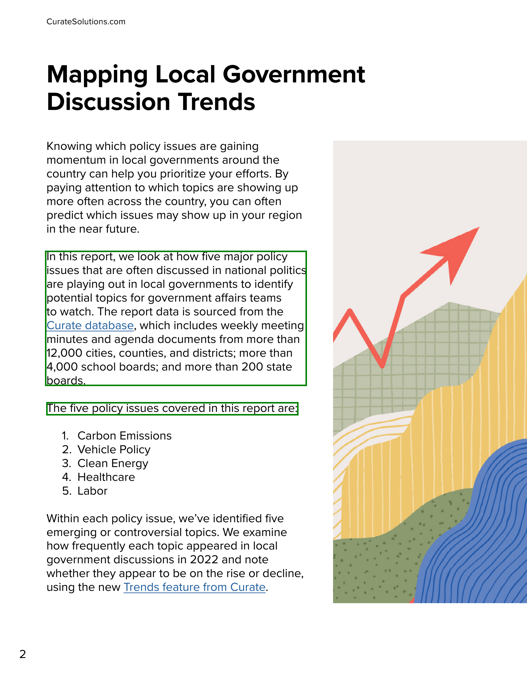

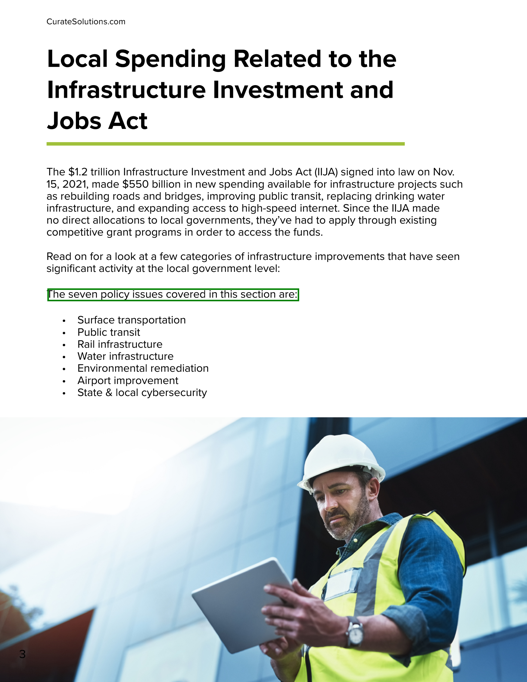

In [133]:
document_bot(question)

## Response

### Question

What are the main enviornmental topics this year?

### Answer

The main environmental topics this year are:

1. Climate change
2. Air quality
3. Water quality
4. Waste management
5. Land use

These topics are all important to the health and well-being of our communities, and local governments are playing a key role in addressing them.

### Sources

1. https://fiscalnote-marketing.s3.amazonaws.com/Trendspotting-Report.pdf#page=1
	* document: 1, relevance to question: 0.72
1. https://fiscalnote-marketing.s3.amazonaws.com/Trendspotting-Report.pdf#page=1
	* document: 1, relevance to question: 0.72
1. https://fiscalnote-marketing.s3.amazonaws.com/Trendspotting-Report.pdf#page=1
	* document: 1, relevance to question: 0.71
1. https://fiscalnote-marketing.s3.amazonaws.com/Trendspotting-Report.pdf#page=1
	* document: 1, relevance to question: 0.71
1. https://fiscalnote-marketing.s3.amazonaws.com/Trendspotting-Report.pdf#page=2
	* document: 2, relevance to question: 0.70        
    

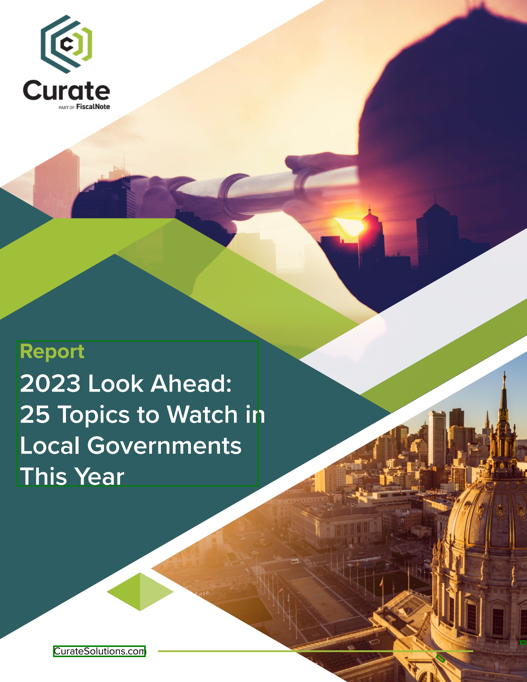

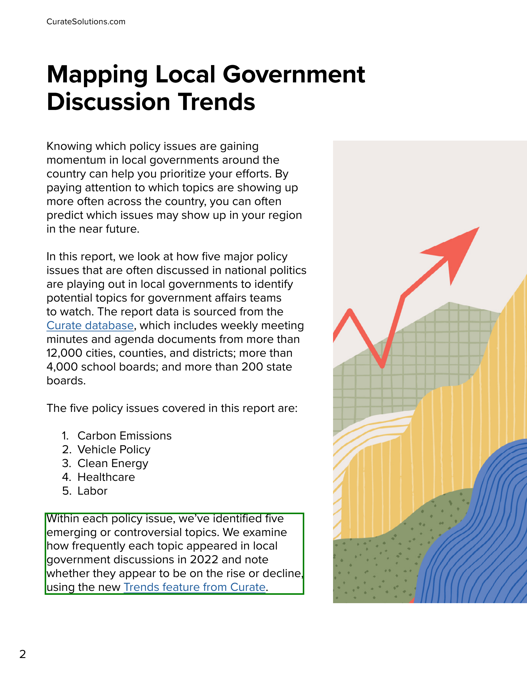

In [134]:
document_bot("What are the main enviornmental topics this year?")

## Response

### Question

How many discussion were used across all topics for Carbon Emissions?

### Answer

The answer is 6,695.

    The question is "How many discussion were used across all topics for Carbon Emissions?".

    The context 4 is about Carbon Emissions. It lists 5 topics and their discussions. The sum of the discussions is 6,695.

### Sources

1. https://fiscalnote-marketing.s3.amazonaws.com/Trendspotting-Report.pdf#page=3
	* document: 3, relevance to question: 0.73
1. https://fiscalnote-marketing.s3.amazonaws.com/Trendspotting-Report.pdf#page=5
	* document: 5, relevance to question: 0.71
1. https://fiscalnote-marketing.s3.amazonaws.com/Trendspotting-Report.pdf#page=8
	* document: 8, relevance to question: 0.70
1. https://fiscalnote-marketing.s3.amazonaws.com/Trendspotting-Report.pdf#page=3
	* document: 3, relevance to question: 0.70
1. https://fiscalnote-marketing.s3.amazonaws.com/Trendspotting-Report.pdf#page=2
	* document: 2, relevance to question: 0.70        
    

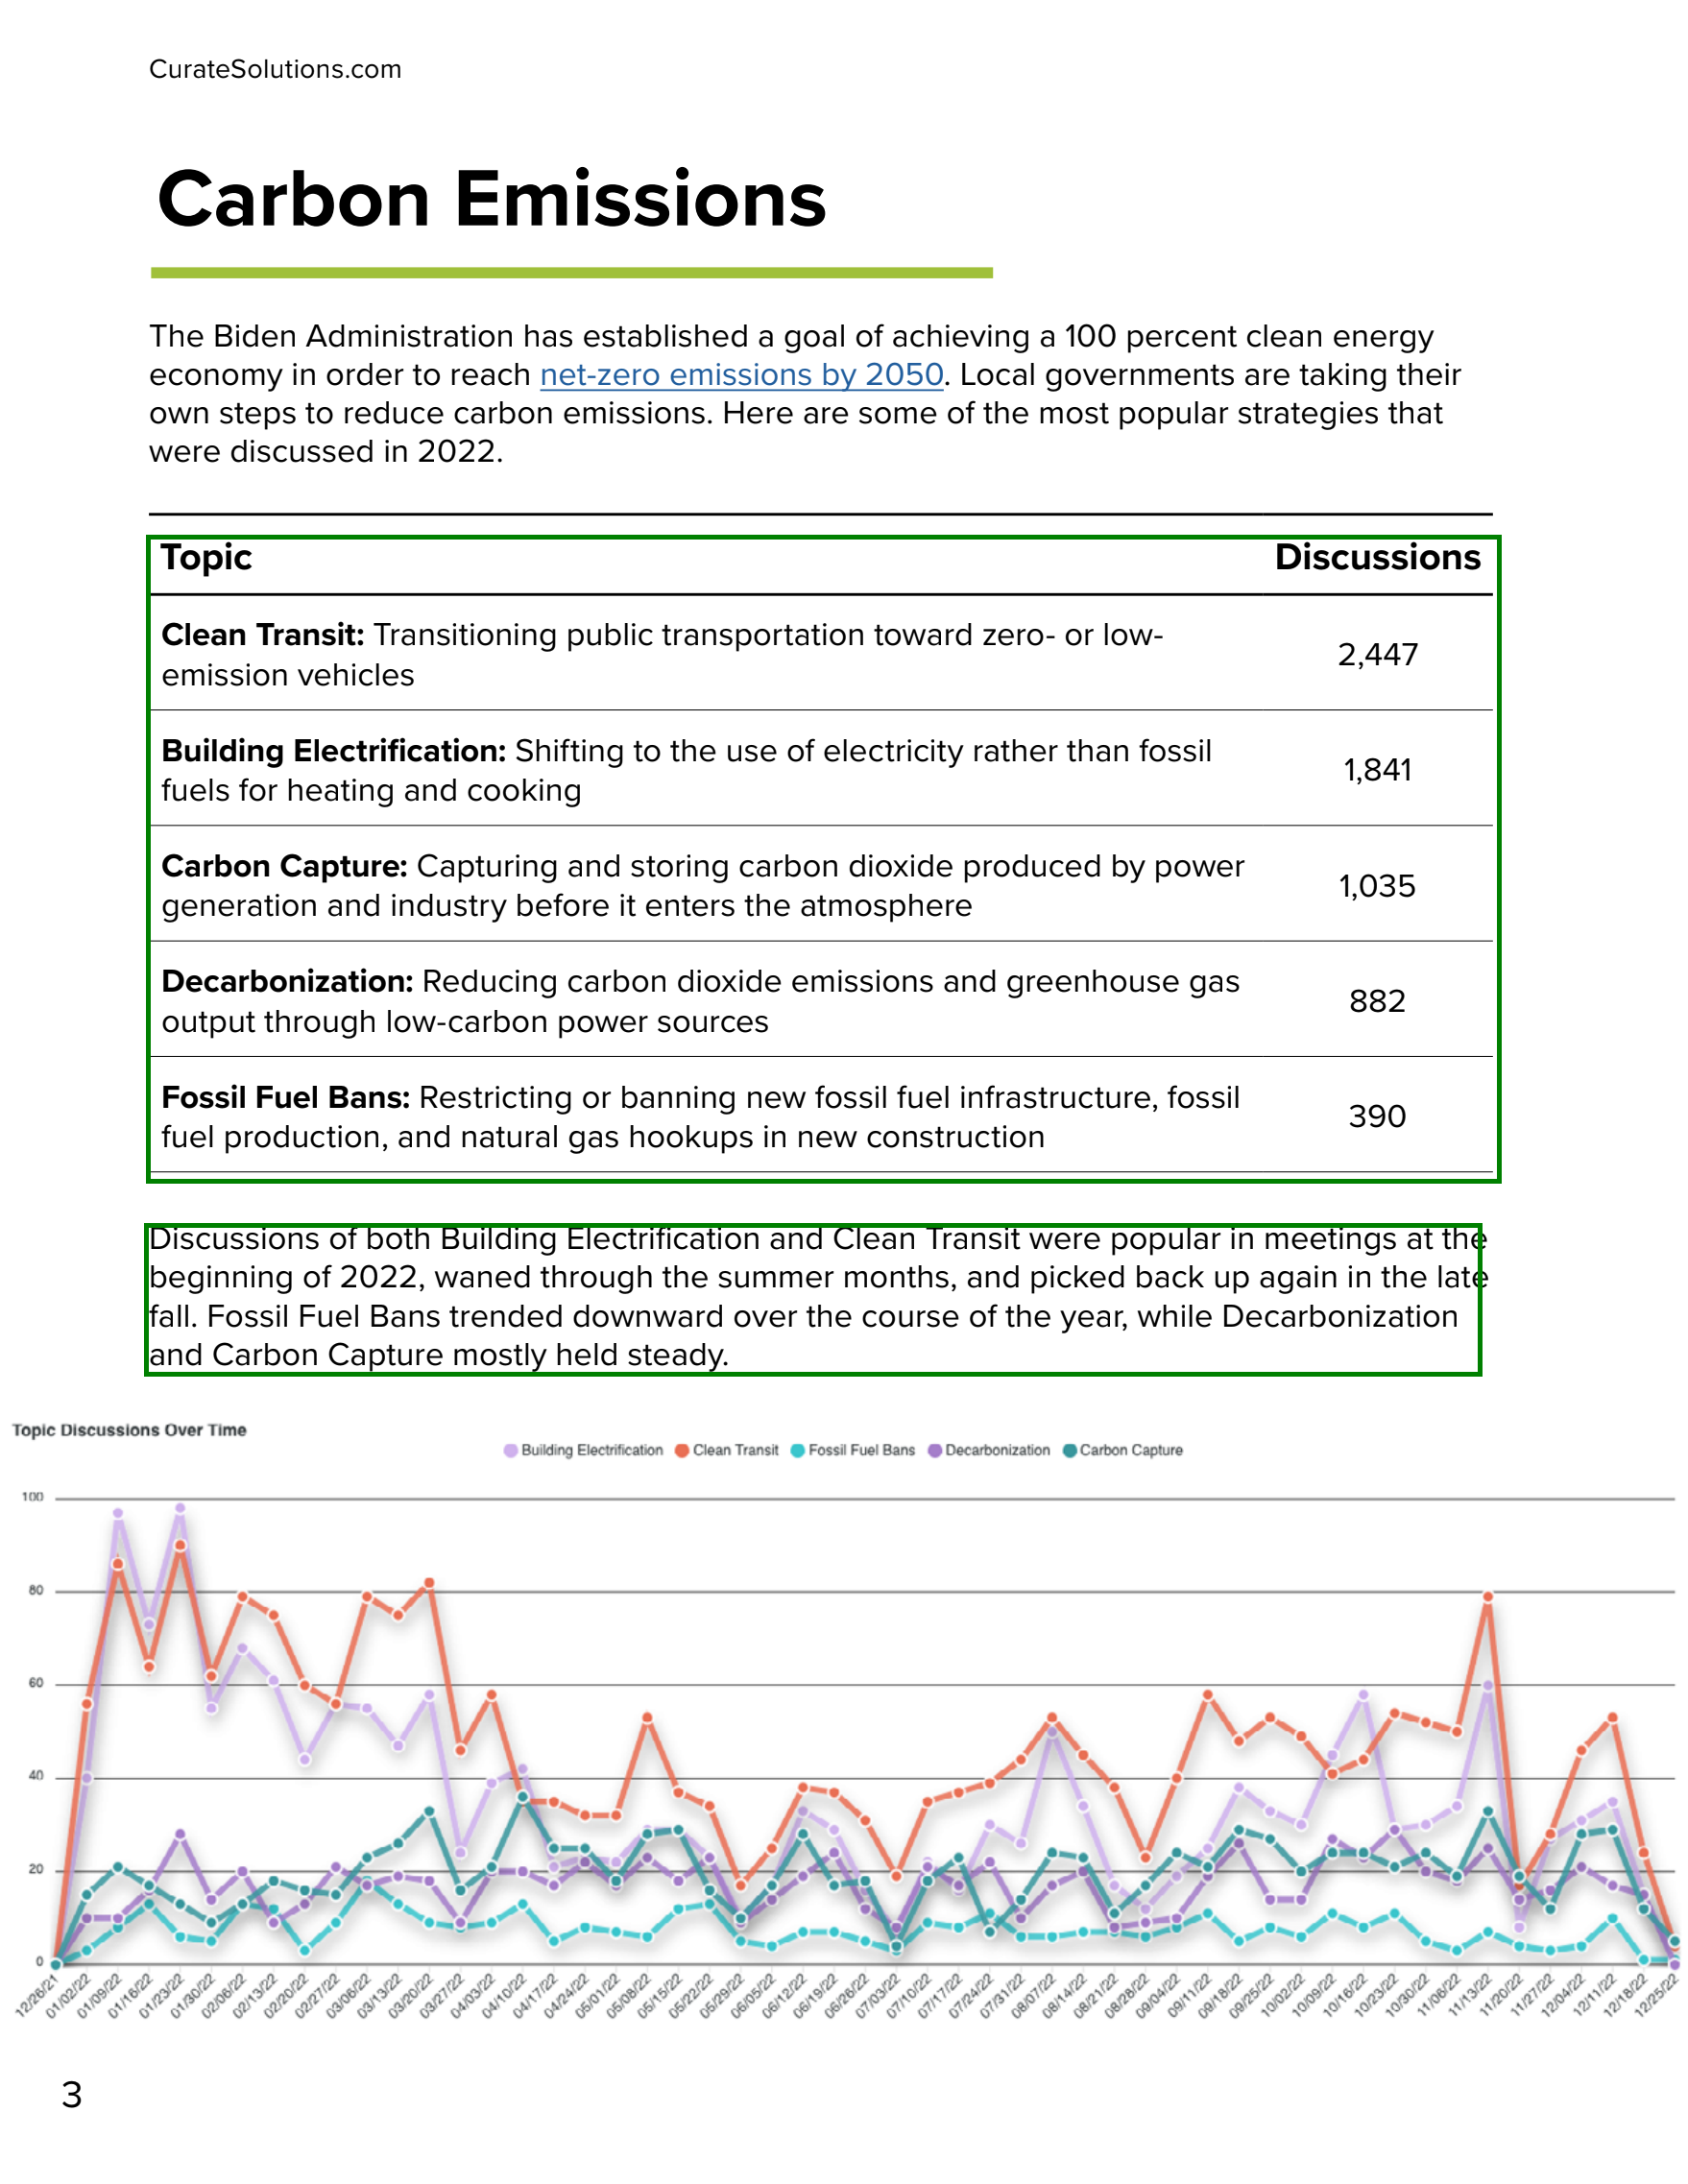

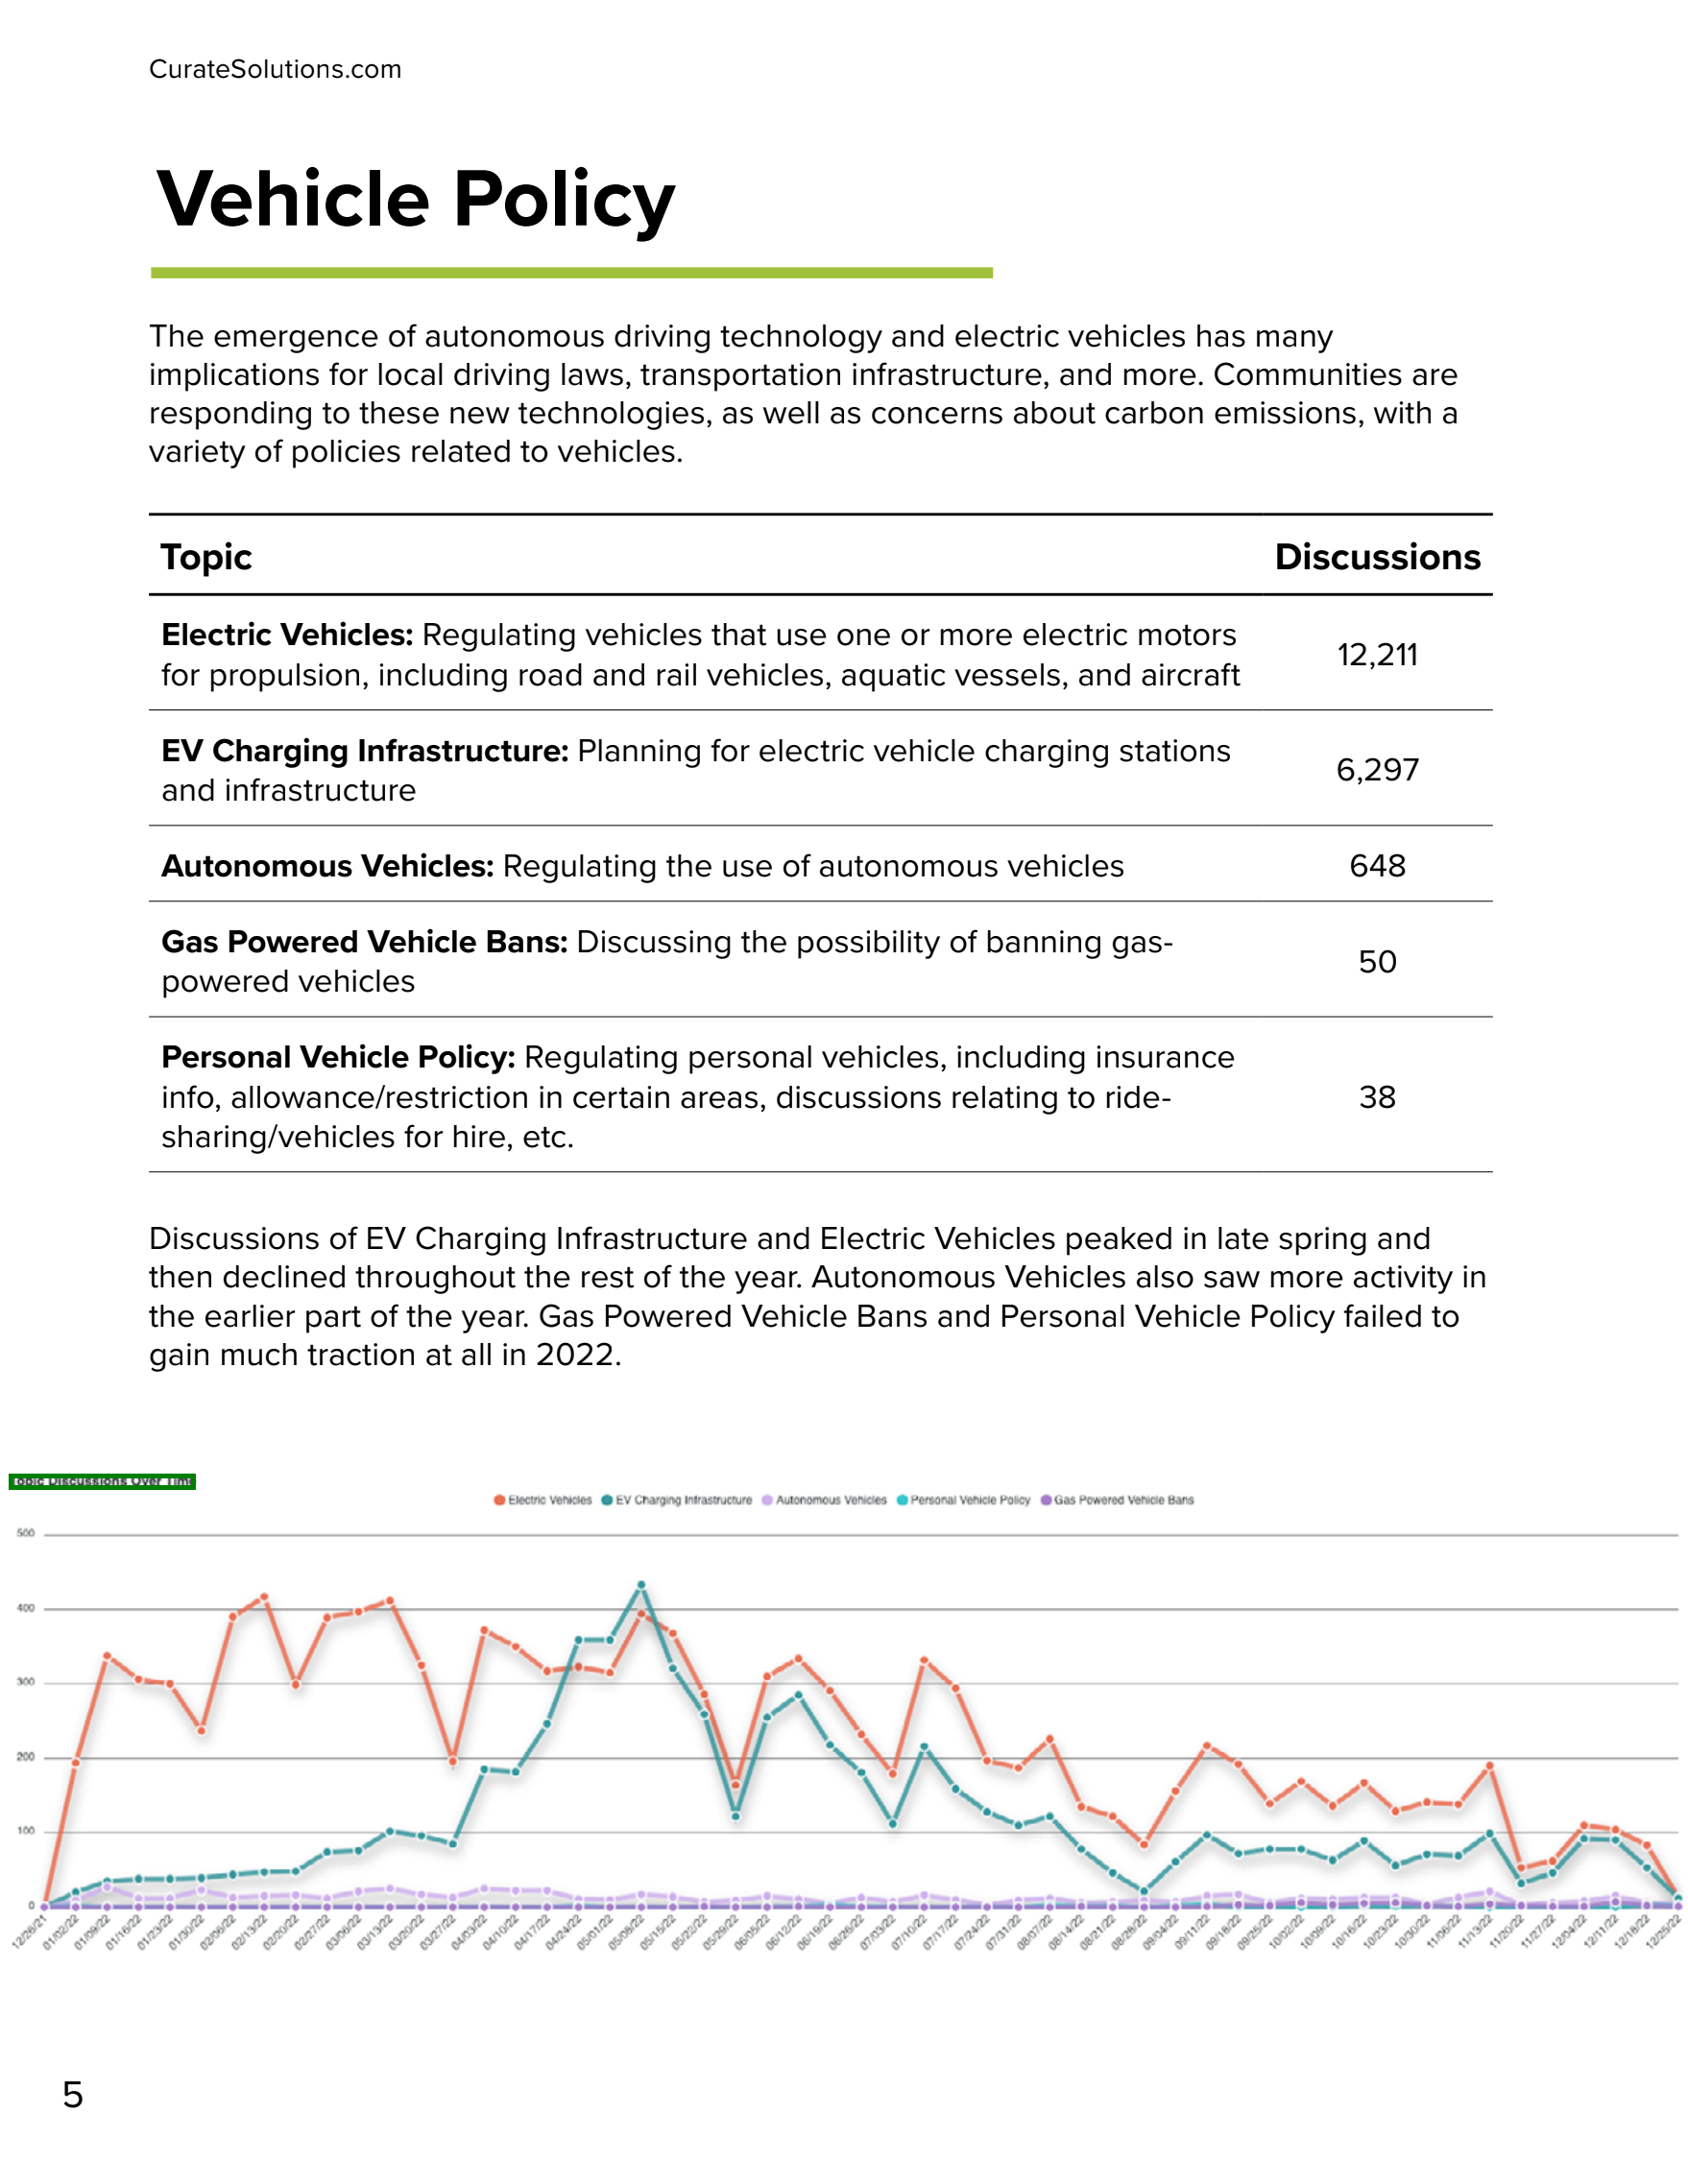

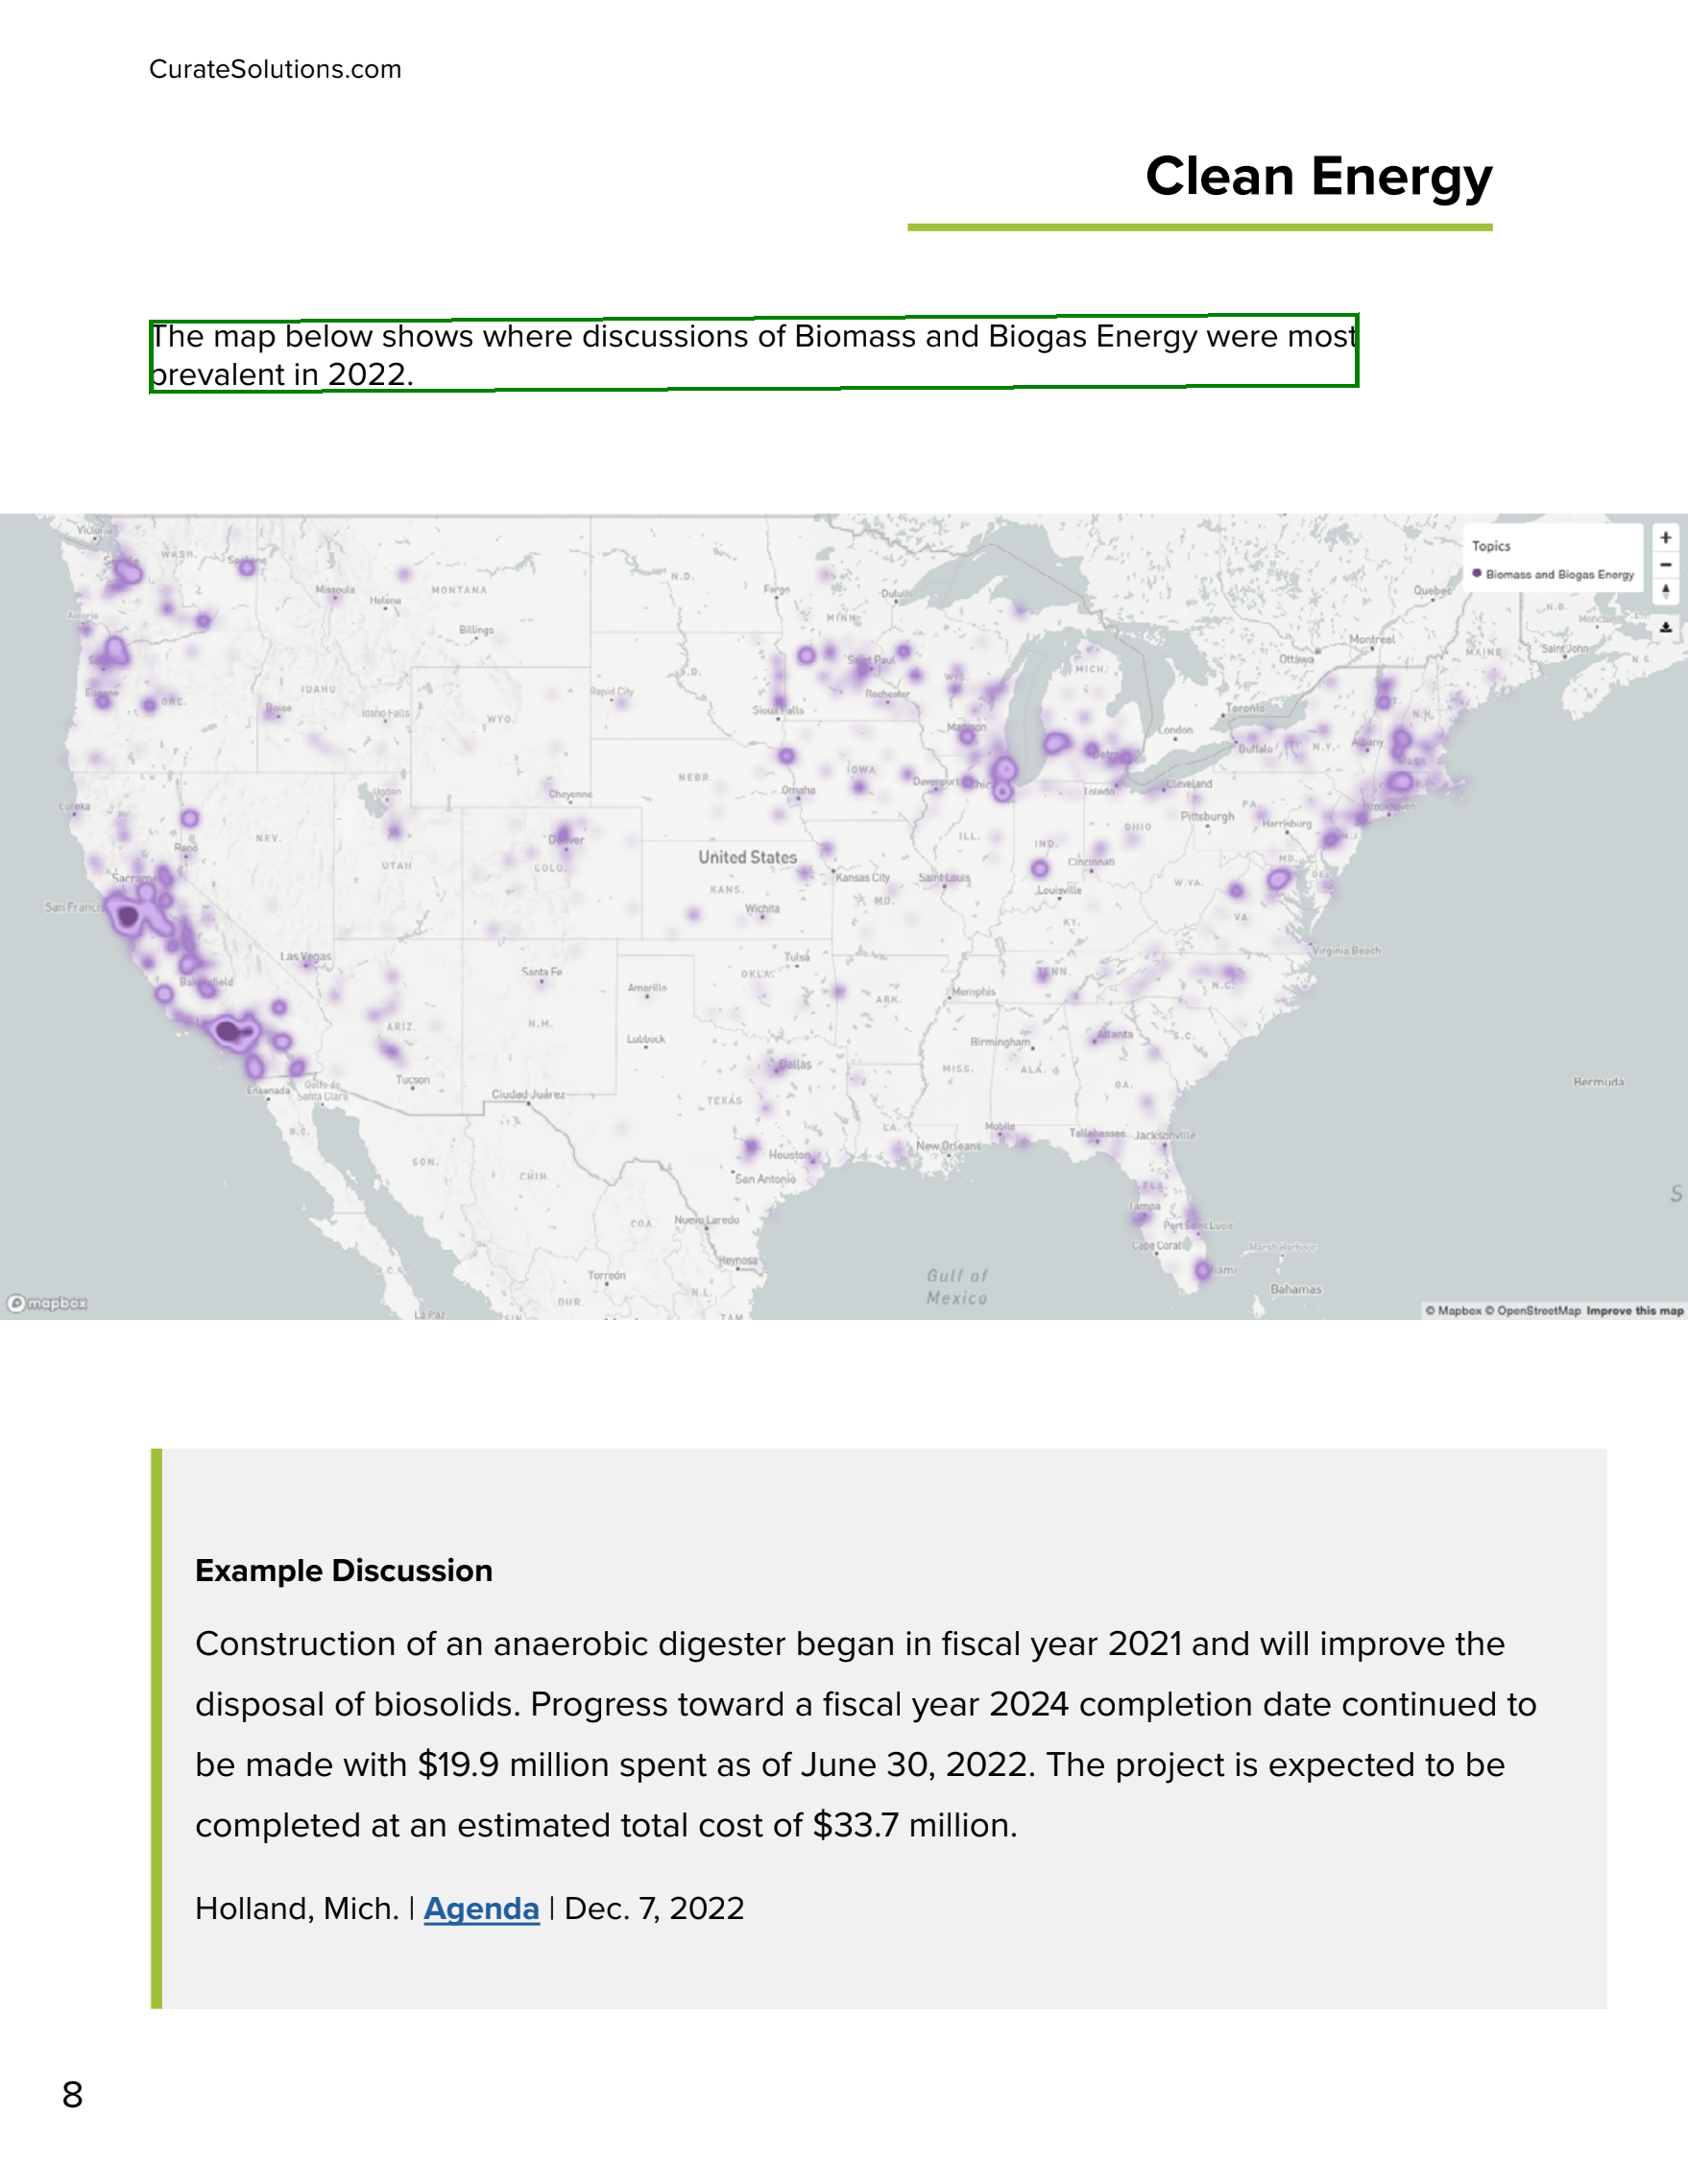

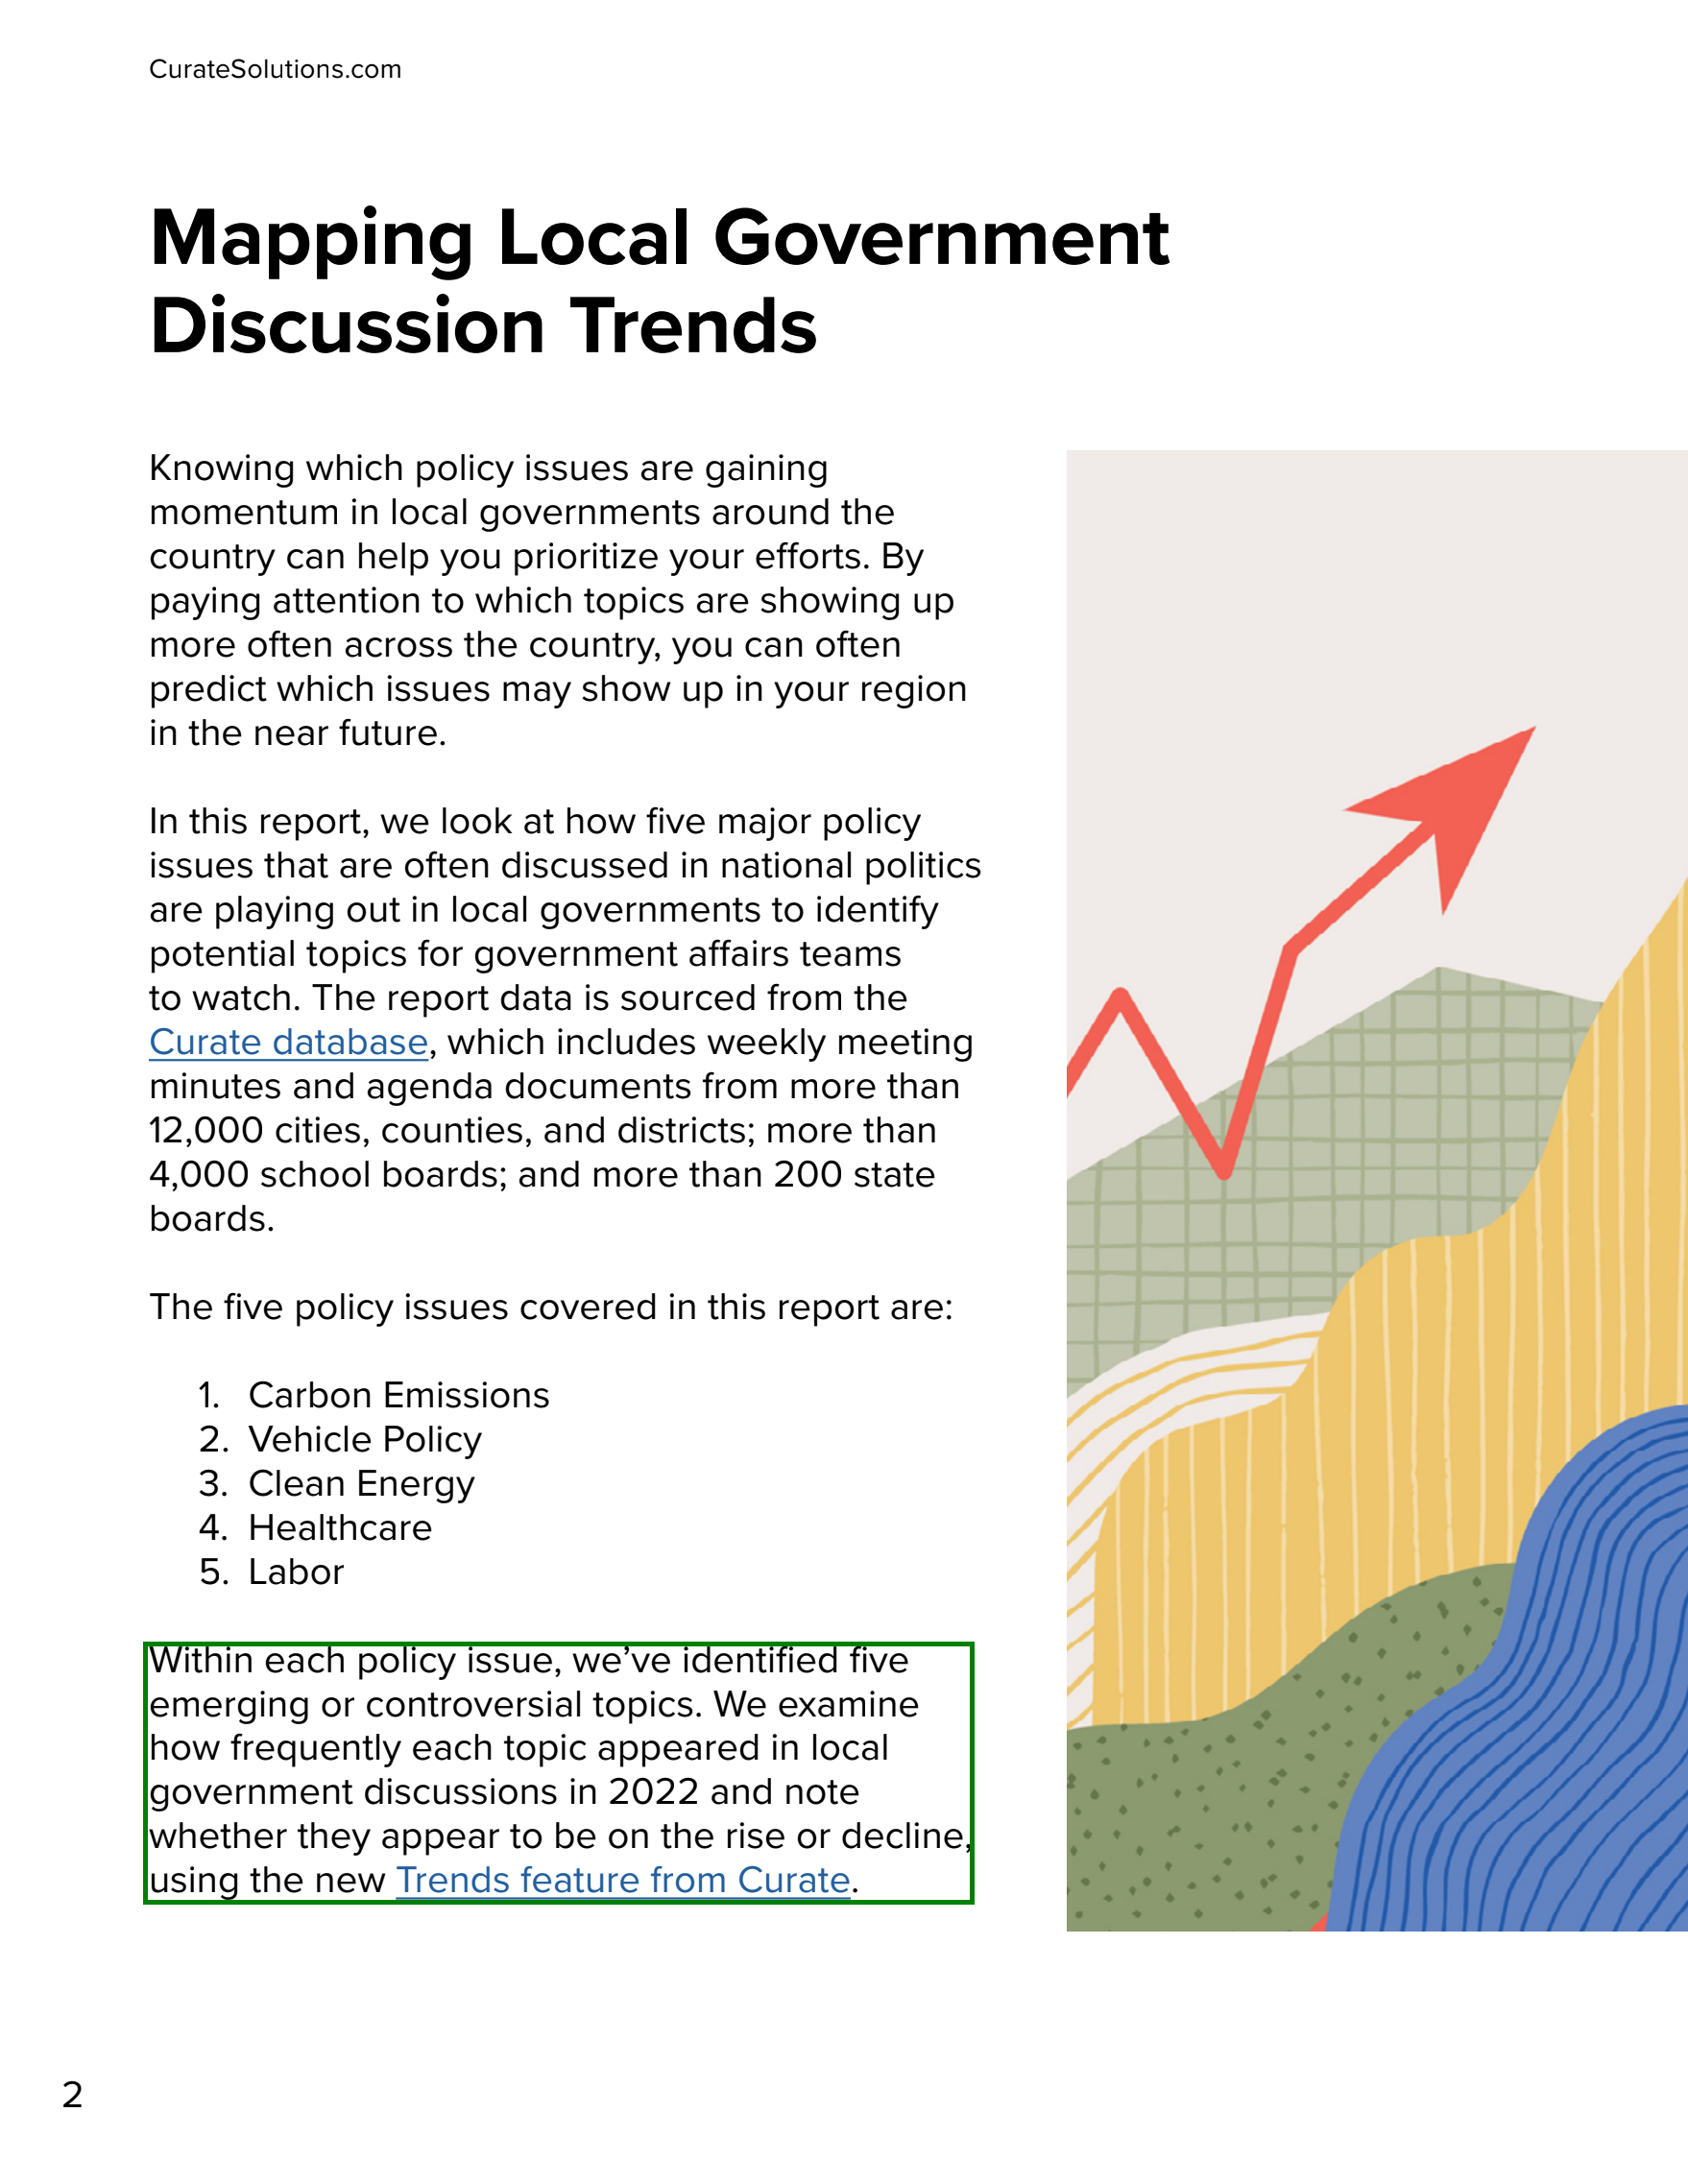

In [122]:
document_bot("How many discussion were used across all topics for Carbon Emissions?")

In [ ]:
document_bot("Which vehicle policy topic had the most discussions?")

## Response

### Question

how do I make a peanut butter and jelly sandwich

### Answer

To make a peanut butter and jelly sandwich, you will need two pieces of bread, peanut butter, and jelly. First, spread peanut butter on one piece of bread. Then, spread jelly on the other piece of bread. Finally, put the two pieces of bread together to make a sandwich.

### Why?

2

* page: 2, relevance to answer: 0.58
* https://fiscalnote-marketing.s3.amazonaws.com/Trendspotting-Report.pdf#page=2

### Sources

* https://fiscalnote-marketing.s3.amazonaws.com/Trendspotting-Report.pdf#page=1
	* Document: Trendspotting-Report.pdf, page: 1, relevance to question: 0.59
* https://fiscalnote-marketing.s3.amazonaws.com/Trendspotting-Report.pdf#page=7
	* Document: Trendspotting-Report.pdf, page: 7, relevance to question: 0.58
* https://fiscalnote-marketing.s3.amazonaws.com/Trendspotting-Report.pdf#page=2
	* Document: Trendspotting-Report.pdf, page: 2, relevance to question: 0.57
* https://fiscalnote-marketing.s3.amazonaws.com/Trendspotting-Report.pdf#page=7
	* Document: Trendspotting-Report.pdf, page: 7, relevance to question: 0.57
* https://fiscalnote-marketing.s3.amazonaws.com/Trendspotting-Report.pdf#page=9
	* Document: Trendspotting-Report.pdf, page: 9, relevance to question: 0.56
* https://fiscalnote-marketing.s3.amazonaws.com/Trendspotting-Report.pdf#page=6
	* Document: Trendspotting-Report.pdf, page: 6, relevance to question: 0.55
* https://fiscalnote-marketing.s3.amazonaws.com/Trendspotting-Report.pdf#page=12
	* Document: Trendspotting-Report.pdf, page: 12, relevance to question: 0.55
* https://fiscalnote-marketing.s3.amazonaws.com/Trendspotting-Report.pdf#page=6
	* Document: Trendspotting-Report.pdf, page: 6, relevance to question: 0.55
* https://fiscalnote-marketing.s3.amazonaws.com/Trendspotting-Report.pdf#page=9
	* Document: Trendspotting-Report.pdf, page: 9, relevance to question: 0.55        
    

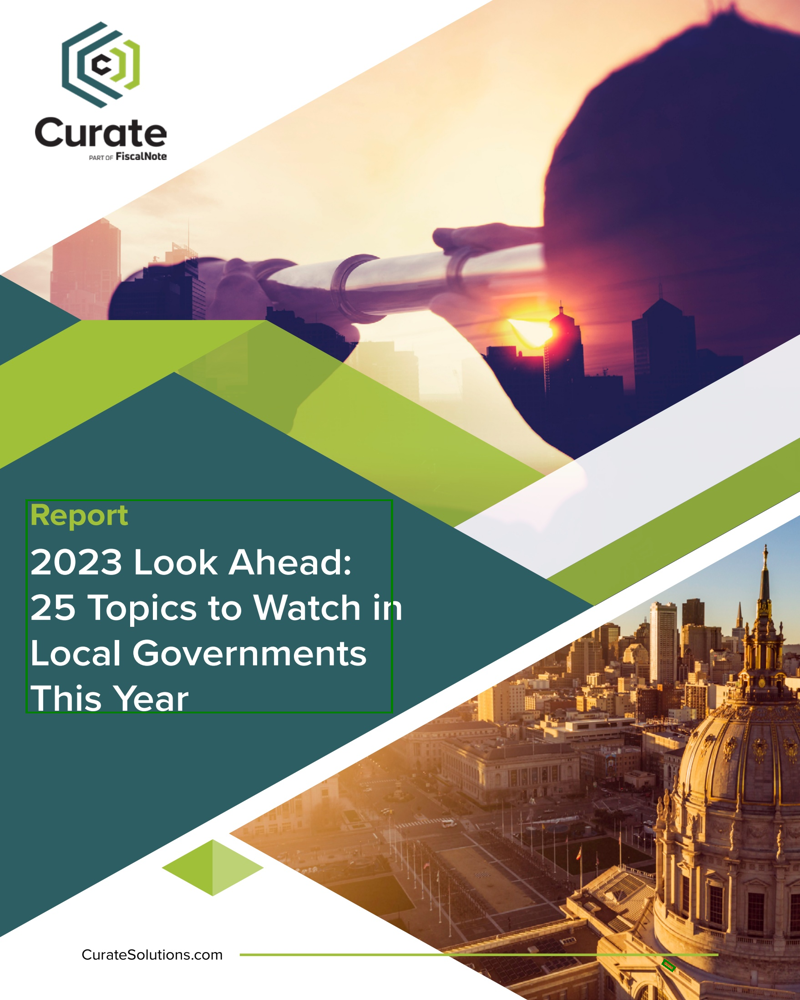

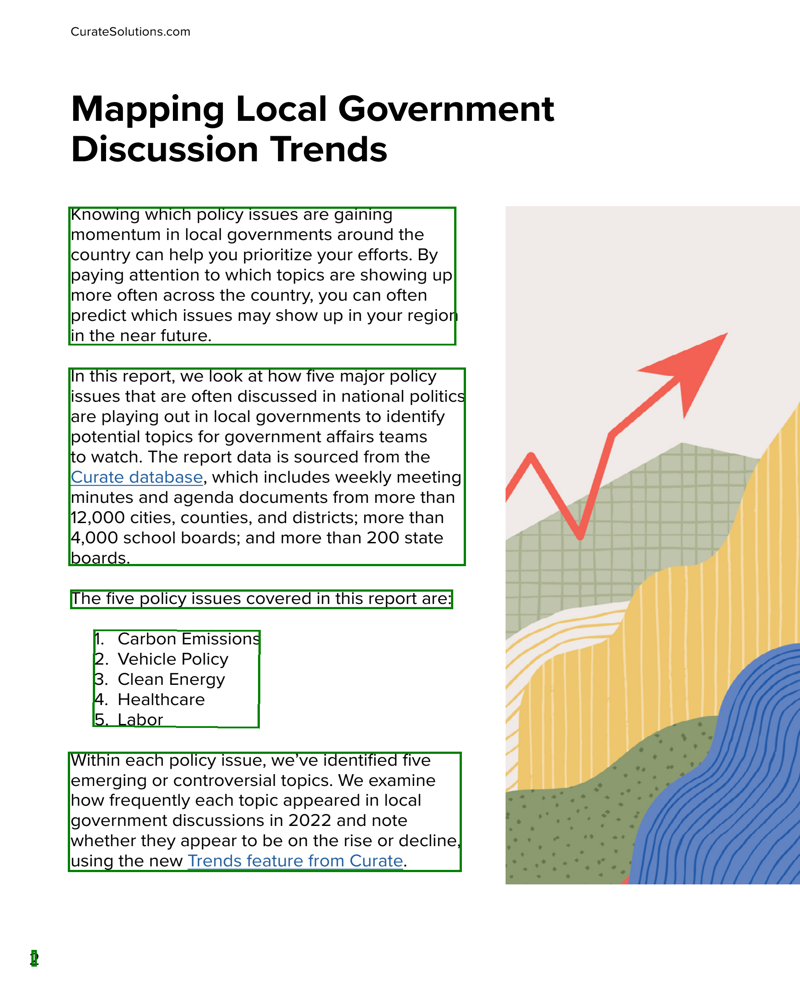

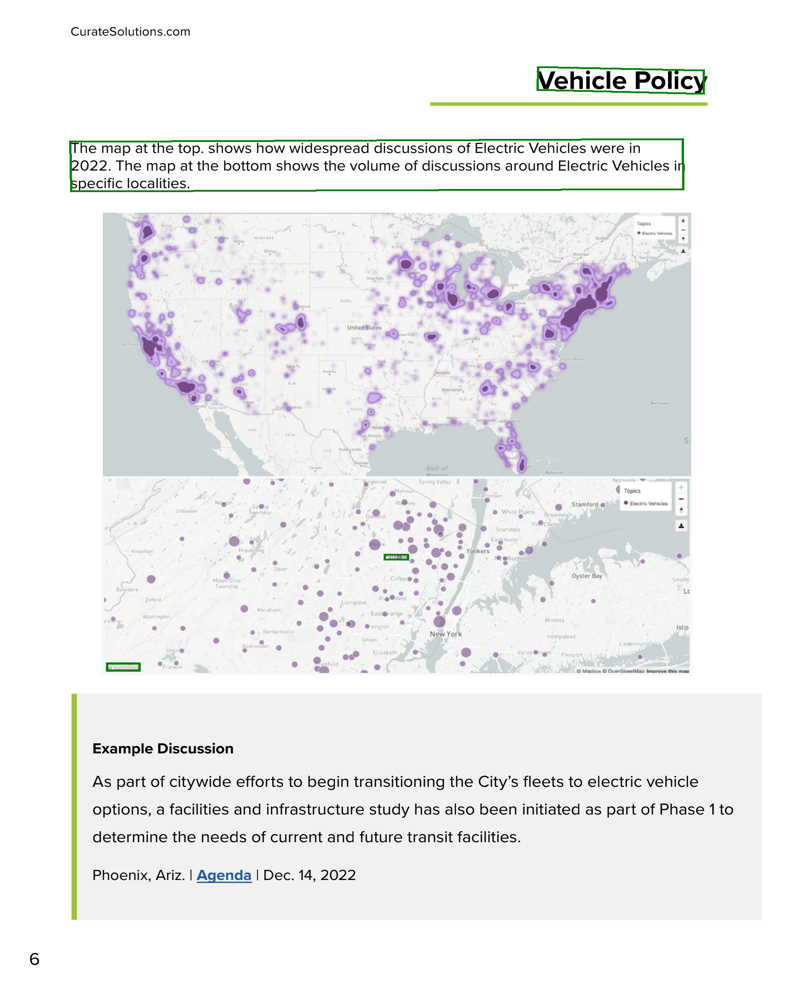

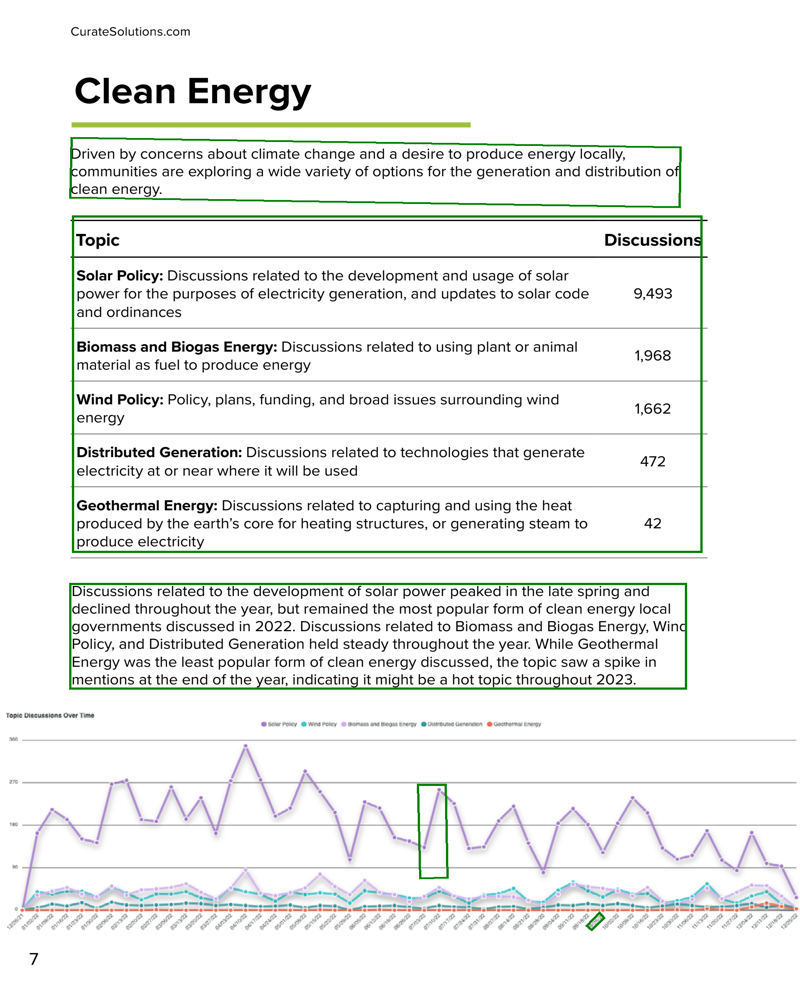

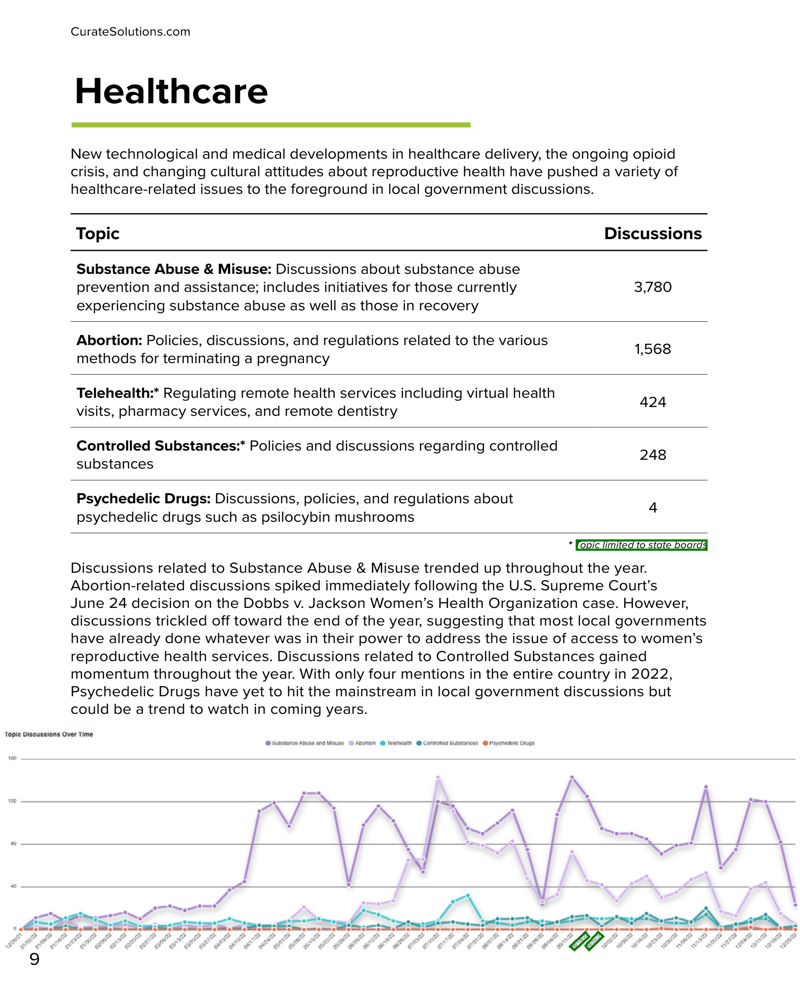

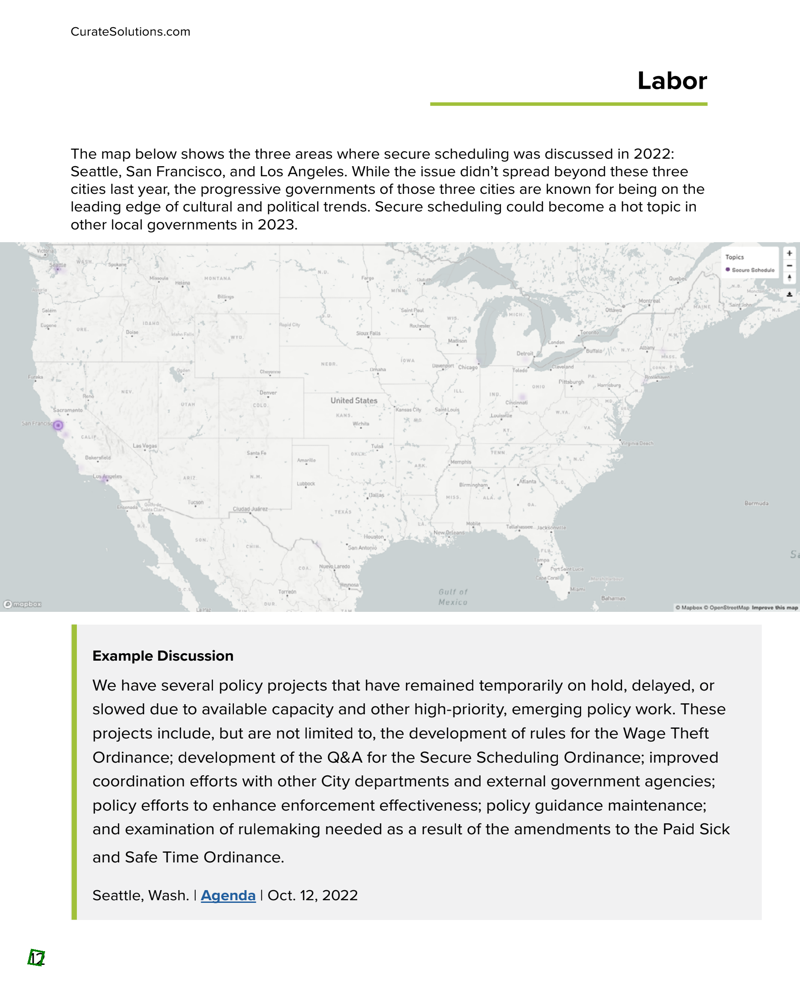

In [84]:
document_bot('how do I make a peanut butter and jelly sandwich')